<a href="https://colab.research.google.com/github/sunny0103/online_course_or_book_reviewnote/blob/main/%5BDeep_Learning_from_Scratch%5D_3_Mnist_%EA%B5%AC%ED%98%84_Comparing_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Mnist Data

In [ ]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import OrderedDict
%matplotlib inline

In [ ]:
mnist = load_digits()

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
pd.DataFrame(mnist.data, columns=mnist.feature_names).head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [ ]:
pd.DataFrame(mnist.target).head()

,0
0,0
1,1
2,2
3,3
4,4


In [ ]:
print('train data shape:',mnist.data.shape)
print('target data shape:',mnist.target.shape)

train data shape: (1797, 64)
target data shape: (1797,)


In [ ]:
print('data minimum:',mnist.data.min())
print('data maximum:',mnist.data.max())

data minimum: 0.0
data maximum: 16.0


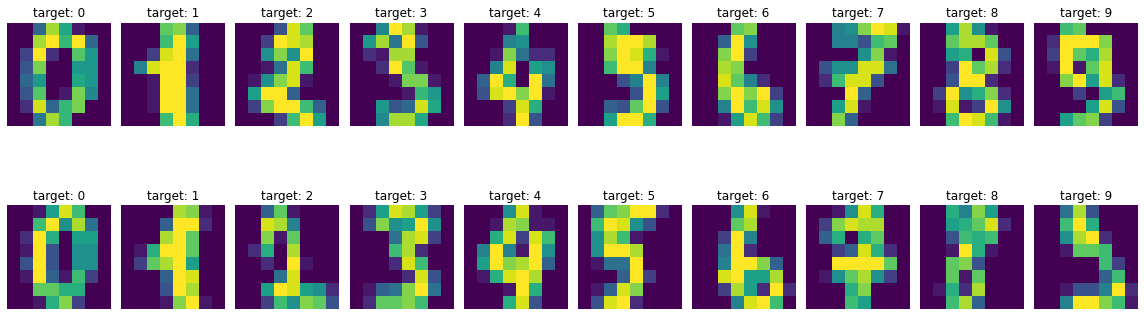

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i]);
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
plt.tight_layout()

## Dataset modification

In [ ]:
# change dataset name to X and y
X = mnist.data
y = mnist.target

In [ ]:
X/=16.0
print(X.min(), X.max())

0.0 1.0


In [ ]:
# Split dataset into 3 : train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(1437, 64) (360, 64)


## Activation Function

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out)* self.out
    return dx

In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.origianl_x_shape = None
    # 가중치와 편향 매개변수의 미분
    self.dW = None
    self.db = None

  def forward(self, x):
    # 텐서대응
    self.origianl_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis =0)
    dx = dx.reshape(*self.origianl_x_shape)
    return dx


In [ ]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis= 0)
    y = np.exp(x) /np.sum(np.exp(x), axis=0)
    return y.T
  x = x - np.max(x) #오버플로 대책
  return np.exp(x) / np.sum(np.exp(x))

In [ ]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  if t.size == y.size: 
    t = t.argmax(axis = 1)
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t]+ 1e-7))/batch_size

In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None # softmax출력
    self.t = None # 정답레이블

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size : #  원핫 인코딩형태일때
      dx = (self.y - self.t)/batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t]-=1
      dx = dx/batch_size
      return dx

## Multilayer Net

In [ ]:
class MultiLayerNet:
    """완전연결 다층 신경망
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, ouput_size, 
               activation='relu', weight_init_std='relu', weight_decay_lambda =0):
      self.input_size = input_size
      self.output_size = ouput_size
      self.hidden_size_list = hidden_size_list
      self.hidden_layer_num = len(hidden_size_list)
      self.weight_decay_lambda = weight_decay_lambda
      self.params = {}

      # 가중치 초기화
      self.__init_weight(weight_init_std)

      # 계층생성
      activation_layer ={'sigmoid': Sigmoid, 'relu': Relu}
      self.layers = OrderedDict() # layer dictionary 생성 
      for idx in range(1, self.hidden_layer_num +1):
        self.layers['Affine' +str(idx)] = Affine(self.params['W'+str(idx)], 
                                               self.params['b'+str(idx)])
        self.layers['Activation_function'+str(idx)]  = activation_layer[activation]()

      idx = self.hidden_layer_num + 1
      self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                             self.params['b' +str(idx)])
      self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        W(previous layer size, current layer size)
        """
        all_size_list = [self.input_size] + self.hidden_size_list+[self.output_size]
        for idx in range(1, len(all_size_list)):
          scale = weight_init_std
          if str(weight_init_std).lower() in ('relu', 'he'): #He 가중치 초기화
            scale = np.sqrt(2.0/ all_size_list[idx-1]) # previous node의 size
          elif str(weight_init_std).lower() in ('sigmoid', 'xavier'): #Xavier가중치 초기화
            scale = np.sqrt(1.0/ all_size_list[idx-1])
          self.params['W'+str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
          self.params['b'+str(idx)] = np.zeros(all_size_list[idx])
    
    def predict(self, x):
      for layer in self.layers.values():
        x = layer.forward(x)
      return x

    def loss(self, x, t):
      y = self.predict(x)
      weight_decay = 0
      for idx in range(1, self.hidden_layer_num +2 ):
        W = self.params['W' +str(idx)]
        weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2) # L2 Norm
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
      y = self.predict(x)
      y = np.argmax(y, asix=1)
      if t.ndim !=1: t = np.argmax(t, axis=1)
      accuracy = np.sum(y ==t)/float(x.shape[0])
      return accuracy

    def gradient(self, x, t):
      # forward
      self.loss(x, t)
      
      # backward
      dout = 1
      dout = self.last_layer.backward(dout)
      layers = list(self.layers.values()) # 각 레이어 마다 가중치와 편향을 가져옴
      layers.reverse() #backward이므로 순서를 뒤집는다.
      for layer in layers:
        dout = layer.backward(dout)

      grads = {}
      for idx in range(1, self.hidden_layer_num+2):
        grads['W' +str(idx)] = self.layers['Affine' +str(idx)].dW + \
                               self.weight_decay_lambda * self.layers['Affine' +str(idx)].W
        grads['b' +str(idx)] = self.layers['Affine'+ str(idx)].db

      return grads

## Optimizer

In [ ]:
class SGD:
  """ 확률적 경사 하강법"""
  def __init__(self, lr=0.01):
    self.lr = lr
  
  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]


In [ ]:
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
      params[key] += self.v[key]
      

In [ ]:
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h= {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key]*grads[key]
      params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key]) + 1e-7)

In [ ]:
class RMSProp:
  def __init__(self, lr=0.01, decay_rate =0.99):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] *= self.decay_rate
      self.h[key] += (1 - self.decay_rate) *grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+1e-7)

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [ ]:
# optimiser 설정
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSProp'] = RMSProp()
optimizers['Adam'] = Adam()

## Training

In [ ]:
train_size = X_train.shape[0]
batch_size = 32
max_iterations = 2000

In [ ]:
networks ={}
train_loss= {}
for key in optimizers.keys():
  networks[key] = MultiLayerNet(input_size =64, hidden_size_list=[32, 32, 32, 32], ouput_size =10)
  train_loss[key] = []

In [ ]:
# Training
for i in range(max_iterations):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = X_train[batch_mask]
  t_batch = y_train[batch_mask]

  for key in optimizers.keys():
    grads = networks[key].gradient(x_batch, t_batch)
    optimizers[key].update(networks[key].params, grads)
    loss = networks[key].loss(x_batch, t_batch)
    train_loss[key].append(loss)

  if i % 100 ==0:
    print('---------'+"iteration:"+str(i)+'------------')
    for key in optimizers.keys():
      loss = networks[key].loss(x_batch, t_batch)
      print(key +":"+str(loss))


---------iteration:0------------
SGD:2.5426327317766084
Momentum:2.3999697902502657
AdaGrad:2.114397383526094
RMSProp:11.88018936265046
Adam:2.3991446755947066
---------iteration:100------------
SGD:2.0111556496132614
Momentum:0.3952872588330756
AdaGrad:0.3213142773258588
RMSProp:0.5465008035191872
Adam:0.7763791423381385
---------iteration:200------------
SGD:1.6638690856801661
Momentum:0.09054294665280188
AdaGrad:0.295557864619152
RMSProp:0.30761115487123747
Adam:0.2874348097577343
---------iteration:300------------
SGD:1.187912190775126
Momentum:0.08952127188677354
AdaGrad:0.05343148008860999
RMSProp:0.033862014281719255
Adam:0.1492948451904112
---------iteration:400------------
SGD:0.9810173113043514
Momentum:0.11161086907785955
AdaGrad:0.21112551671797644
RMSProp:0.0296944321548032
Adam:0.16710463196889033
---------iteration:500------------
SGD:0.5270013427019683
Momentum:0.036824571213558435
AdaGrad:0.08992496618878346
RMSProp:0.02074661312926226
Adam:0.035448022475579655
-------

## Graph Comparison

In [ ]:
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


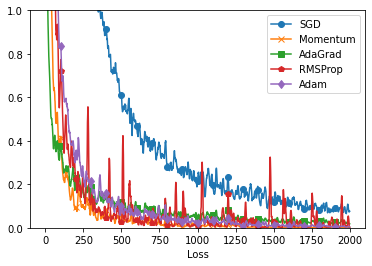

In [ ]:
markers = {'SGD': 'o', "Momentum":'x', "AdaGrad":'s',"RMSProp": 'p', 'Adam':'d'}
x = np.arange(max_iterations)
for key in optimizers.keys():
  plt.plot(x, smooth_curve(train_loss[key]), marker= markers[key], markevery =100, label = key)
plt.xlabel('Iteration')
plt.xlabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()